### Model Evaluation - Coverage, Scalability, Exploration

In [22]:
import time
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import import_ipynb
import feature_engineering

import surprise
from surprise import dataset
from surprise import BaselineOnly

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#### 1. Reading Data

In [7]:
# fetch data objects using defined functions

# ratings, business, checkin, user, tips = feature_engineering.get_yelp_data()
# user = feature_engineering.add_user_features(user, ratings, tips)
# business = feature_engineering.add_item_features(business, checkin)
# ratings = feature_engineering.add_features_to_ratings(ratings, user, business)
# ratings_train, ratings_validation, ratings_test = feature_engineering.train_validation_test_split(years = 1)
# ratings_recommend = feature_engineering.user_recommendation_options(ratings_train)

In [15]:
# fetch data objects from saved pickle files

ratings_train = pickle.load(open("data/ratings_train_5_years.pkl", "rb"))
ratings_validation = pickle.load(open("data/ratings_validation_5_years.pkl", "rb"))
ratings_test = pickle.load(open("data/ratings_test_5_years.pkl", "rb"))
ratings_recommend = pickle.load(open("data/ratings_recommendation_list.pkl", "rb"))

# to rerun all jupyter workflows for 6, 7, 8, 9 years of data for scalability - save values

# model predictions for coverage calculation
wide_deep_recommendations = pickle.load(open("data/wide_and_deep_recommendations.pkl", "rb"))
light_fm_recommendations = pickle.load(open("data/light_fm_recommendations.pkl", "rb"))
xgboost_recommendations = pickle.load(open("data/xgboost_recommendations.pkl", "rb"))

#### 2. Baseline Model - ALS

In [4]:
def baseline_model_train(ratings_train):
    bsl_options = {'method': 'als', 'n_epochs': 20}
    model = surprise.BaselineOnly(bsl_options = bsl_options)

    reader = surprise.Reader(rating_scale = (1,5))
    ratings = surprise.Dataset.load_from_df(ratings_train[['user_id', 'business_id', 'rating']], reader)
    ratings_train = ratings.build_full_trainset()

    model.fit(ratings_train)
    return model

In [5]:
def baseline_model_predict(model, ratings_test):
    predictions = pd.DataFrame(columns = ['user_id', 'business_id', 'pred_rating'])
    for i in range(len(ratings_test)):
        pred = model.predict(ratings_test.user_id[i], ratings_test.business_id[i])
        predictions.loc[i, 'user_id'] = pred.uid
        predictions.loc[i, 'business_id'] = pred.iid
        predictions.loc[i, 'pred_rating'] = pred.est
        
    return predictions

In [6]:
def multiclass_roc_auc_score(y_test, y_pred, average = "macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    return roc_auc_score(y_test, y_pred, average = average)

In [16]:
def basline_model_eval(predictions, ratings_test):
    predictions.pred_rating = predictions.pred_rating.apply(np.round).astype(np.double)    
    recall = recall_score(ratings_test['rating'], predictions.pred_rating, average = 'micro')
    precision = precision_score(ratings_test['rating'], predictions.pred_rating, average = 'micro')
    auc = multiclass_roc_auc_score(ratings_test['rating'], predictions.pred_rating, average = 'micro')
    
    return recall, precision, auc

In [19]:
start = time.time()
model = baseline_model_train(ratings_train)
end = time.time()

print('\nTime Elapsed = '+str(np.round(end - start, 4))+' secs')

Estimating biases using als...

Time Elapsed = 1.8806 secs


In [21]:
predictions_val = baseline_model_predict(model, ratings_validation)
val_recall, val_precision, val_auc = basline_model_eval(predictions_val, ratings_validation)

print('For Validation Data:\n')
print('AUC = ', np.round(val_auc, 4))
print('Recall = ', np.round(val_recall, 4))
print('Precision = ', np.round(val_precision, 4))

predictions_test = baseline_model_predict(model, ratings_test)
test_recall, test_precision, test_auc = basline_model_eval(predictions_test, ratings_test)

print('For Test Data:\n')
print('AUC = ', np.round(test_auc, 4))
print('Recall = ', np.round(test_recall, 4))
print('Precision = ', np.round(test_precision, 4))

For Validation Data:

AUC =  0.5468
Recall =  0.2749
Precision =  0.2749
For Test Data:

AUC =  0.5364
Recall =  0.2582
Precision =  0.2582


#### 3. Recommendation Coverage

In [87]:
def model_coverage(ratings_train, ratings_recommend):
    items_train = len(ratings_train.business_id.unique())
    items_recommended = len(ratings_recommend.business_id.unique())
    
    coverage = np.round(items_recommend / items_train, 4)
    
    return coverage

In [90]:
wide_deep_coverage = model_coverage(ratings_train, wide_deep_recommendations)
light_fm_coverage = model_coverage(ratings_train, light_fm_recommendations)
xgboost_coverage = model_coverage(ratings_train, xgboost_recommendations)

print('Catalog Coverage: \n')
print('Wide & Deep Model = '+str(wide_deep_coverage))
print('Factorization Machines = '+str(light_fm_coverage))
print('Doc2Vec + XGBoost Content Based = '+str(xgboost_coverage))

Catalog Coverage: 

Wide & Deep Model = 0.4737
Factorization Machines = 0.2302
Doc2Vec + XGBoost Content Based = 0.5318


#### 4. Model Scalability

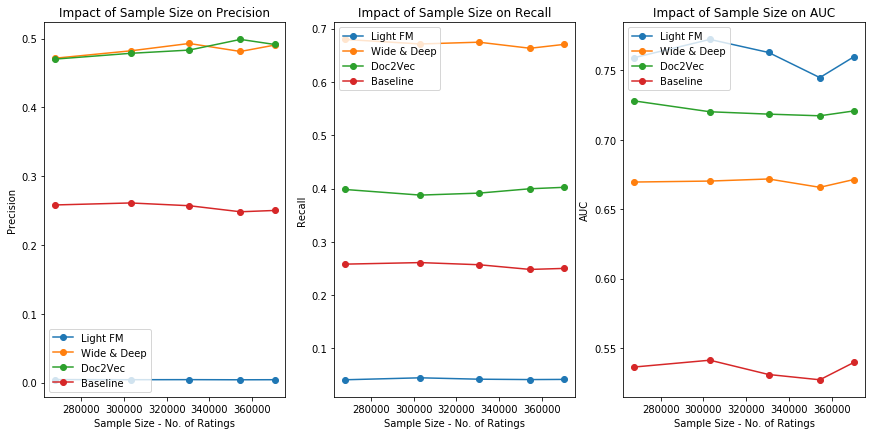

In [65]:
plt.subplots_adjust(0.1, 0.1, 2, 1.4)

plt.subplot(1, 3, 1)
plt.plot(scalability_light_fm['sample_size'], scalability_light_fm['precision'], marker='o')
plt.plot(scalability_wide_deep['sample_size'], scalability_wide_deep['precision'], marker='o')
plt.plot(scalability_xgboost['sample_size'], scalability_xgboost['precision'], marker='o')
plt.plot(scalability_baseline['sample_size'], scalability_baseline['precision'], marker='o')
plt.legend(['Light FM', 'Wide & Deep', 'Doc2Vec', 'Baseline'])
plt.title('Impact of Sample Size on Precision')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('Precision')

plt.subplot(1, 3, 2)
plt.plot(scalability_light_fm['sample_size'], scalability_light_fm['recall'], marker='o')
plt.plot(scalability_wide_deep['sample_size'], scalability_wide_deep['recall'], marker='o')
plt.plot(scalability_xgboost['sample_size'], scalability_xgboost['recall'], marker='o')
plt.plot(scalability_baseline['sample_size'], scalability_baseline['recall'], marker='o')
plt.legend(['Light FM', 'Wide & Deep', 'Doc2Vec', 'Baseline'])
plt.title('Impact of Sample Size on Recall')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('Recall')

plt.subplot(1, 3, 3)
plt.plot(scalability_light_fm['sample_size'], scalability_light_fm['auc'], marker='o')
plt.plot(scalability_wide_deep['sample_size'], scalability_wide_deep['auc'], marker='o')
plt.plot(scalability_xgboost['sample_size'], scalability_xgboost['auc'], marker='o')
plt.plot(scalability_baseline['sample_size'], scalability_baseline['auc'], marker='o')
plt.legend(['Light FM', 'Wide & Deep', 'Doc2Vec', 'Baseline'])
plt.title('Impact of Sample Size on AUC')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('AUC')

plt.show()

Text(0, 0.5, 'Time (secs)')

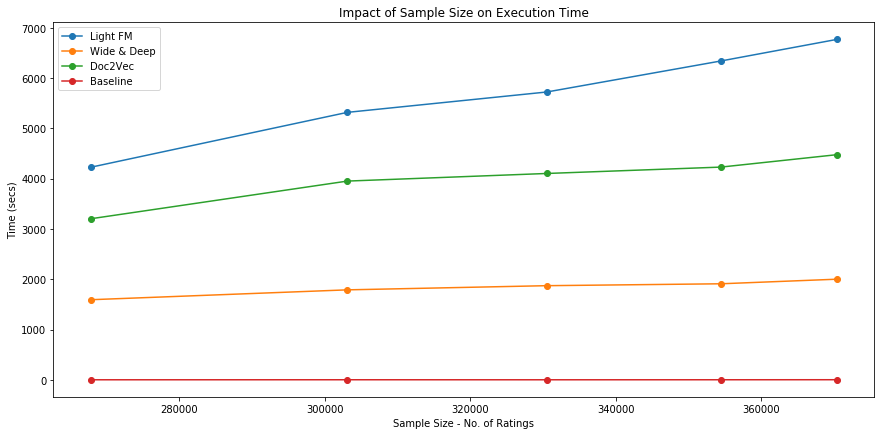

In [67]:
plt.subplots_adjust(0.1, 0.1, 2, 1.4)

plt.subplot(1, 1, 1)
plt.plot(scalability_light_fm['sample_size'], scalability_light_fm['elapsed_time'], marker='o')
plt.plot(scalability_wide_deep['sample_size'], scalability_wide_deep['elapsed_time'], marker='o')
plt.plot(scalability_xgboost['sample_size'], scalability_xgboost['elapsed_time'], marker='o')
plt.plot(scalability_baseline['sample_size'], scalability_baseline['elapsed_time'], marker='o')
plt.legend(['Light FM', 'Wide & Deep', 'Doc2Vec', 'Baseline'])
plt.title('Impact of Sample Size on Execution Time')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('Time (secs)')

#### 5. Factorization Machine Exploration

Text(0, 0.5, 'Accuracy')

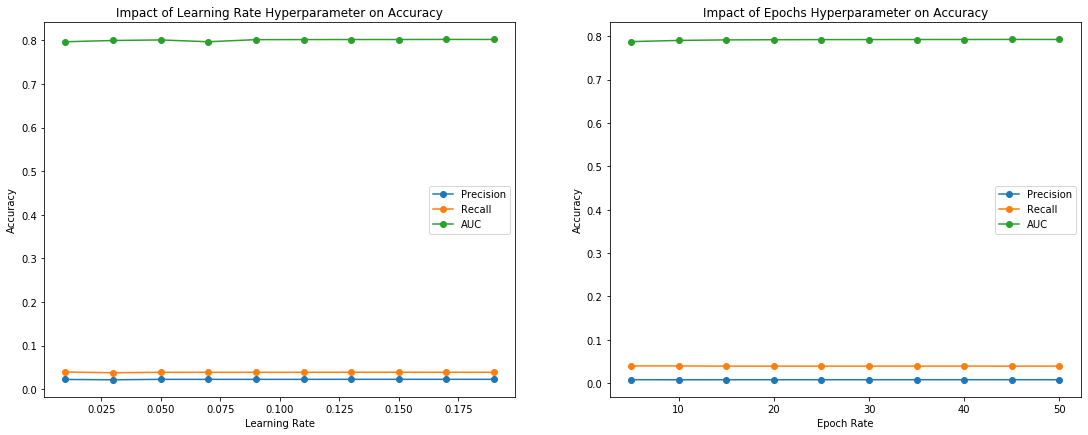

In [79]:
# Factorization Machine Hyperparameter Analysis
plt.subplots_adjust(0.1, 0.1, 2.5, 1.4)

plt.subplot(1, 2, 1)
plt.plot(fm_learning_rate['learning_rate'], fm_learning_rate['train_precision'], marker='o')
plt.plot(fm_learning_rate['learning_rate'], fm_learning_rate['train_recall'], marker='o')
plt.plot(fm_learning_rate['learning_rate'], fm_learning_rate['train_auc'], marker='o')
plt.legend(['Precision', 'Recall', 'AUC'])
plt.title('Impact of Learning Rate Hyperparameter on Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['validation_precision'], marker='o')
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['validation_recall'], marker='o')
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['validation_auc'], marker='o')
plt.legend(['Precision', 'Recall', 'AUC'])
plt.title('Impact of Epochs Hyperparameter on Accuracy')
plt.xlabel('Epoch Rate')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

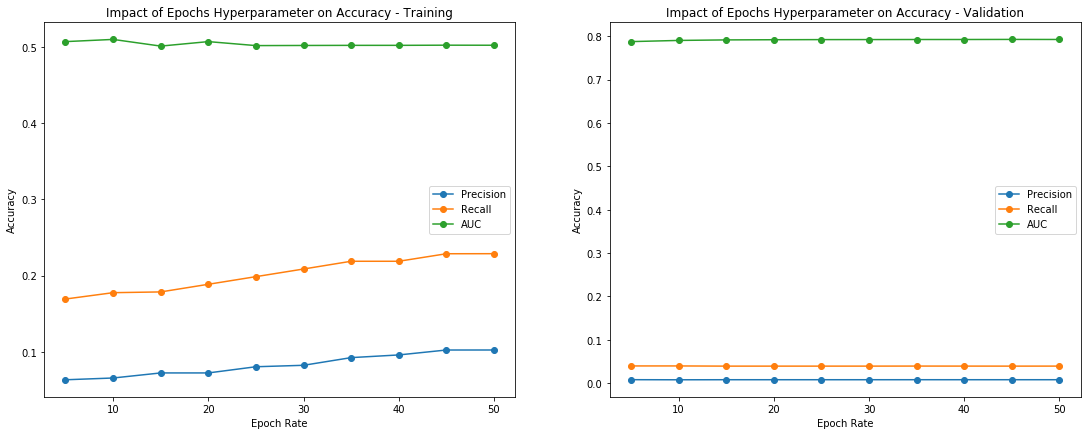

In [86]:
plt.subplots_adjust(0.1, 0.1, 2.5, 1.4)

plt.subplot(1, 2, 1)
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['train_precision'], marker='o')
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['train_recall'], marker='o')
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['train_auc'], marker='o')
plt.legend(['Precision', 'Recall', 'AUC'])
plt.title('Impact of Epochs Hyperparameter on Accuracy - Training')
plt.xlabel('Epoch Rate')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['validation_precision'], marker='o')
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['validation_recall'], marker='o')
plt.plot(fm_learning_rate['epochs'], fm_learning_rate['validation_auc'], marker='o')
plt.legend(['Precision', 'Recall', 'AUC'])
plt.title('Impact of Epochs Hyperparameter on Accuracy - Validation')
plt.xlabel('Epoch Rate')
plt.ylabel('Accuracy')